### About
### Build a machine learning model that can accurately classify the images based on the disease present.

### Import necessary packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import train and test data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### Target label distribution

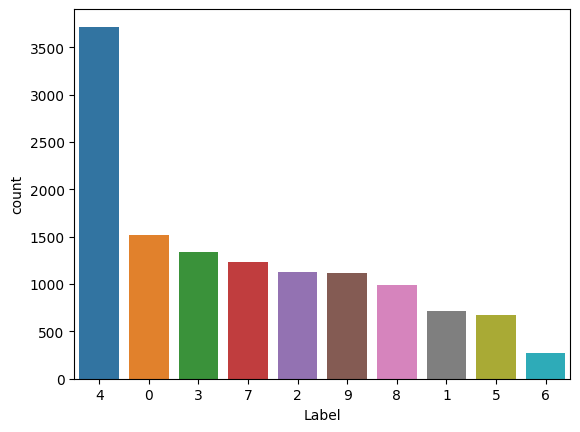

In [3]:
sns.countplot(x=train['Label'],order=train['Label'].value_counts().index);

In [4]:
train['Label'].value_counts()

Label
4    3719
0    1519
3    1335
7    1236
2    1127
9    1122
8     989
1     719
5     678
6     268
Name: count, dtype: int64

### The above plot explains that there is an imbalance between the classes.

### Create train and validation data

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train['Image'], train['Label'], test_size=0.2, random_state=42,stratify=train['Label'])

In [6]:
train_1 = pd.concat([X_train,y_train],axis=1)
val_1 = pd.concat([X_test,y_test],axis=1)

### Function to convert image to 1-D vector.

In [7]:
import os
from tqdm import tqdm_notebook
from PIL import Image, ImageDraw

def createfeat(path,df):
    feat=[]
    for file in tqdm_notebook(df['Image']):
        img=Image.open(f"{(os.path.join(path, file))}").convert("L")
        im=img.resize((128,128))
        image_array = np.array(im)
        # invert the grayscale (black to white , white to black)
        image_array = 255 - image_array
        # Normalize the pixel values between 0 and 1
        normalized_image = image_array / 255.0
        feat.append(normalized_image.flatten())
    return feat

### Create 1-D vector for train images

In [9]:
train_feat = createfeat('train',train_1)

C:\Users\Gandharv Kulkarni\AppData\Local\Temp\ipykernel_26960\3950331475.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm_notebook(df['Image']):


  0%|          | 0/10169 [00:00<?, ?it/s]

### Create 1-D vector for validation images

In [10]:
val_feat = createfeat("train",val_1)

C:\Users\Gandharv Kulkarni\AppData\Local\Temp\ipykernel_26960\3950331475.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm_notebook(df['Image']):


  0%|          | 0/2543 [00:00<?, ?it/s]

#### Create XGBoost classifier with default parameters.

In [11]:
import xgboost as xgb

clf = xgb.XGBClassifier()

### Fit the data

In [12]:
clf.fit(train_feat, y_train,eval_set=[(val_feat,y_test)],eval_metric=['merror','mlogloss'], early_stopping_rounds=10, verbose=True)

c:\Users\Gandharv Kulkarni\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Gandharv Kulkarni\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-merror:0.56469	validation_0-mlogloss:1.99354
[1]	validation_0-merror:0.51435	validation_0-mlogloss:1.82765
[2]	validation_0-merror:0.50177	validation_0-mlogloss:1.71411
[3]	validation_0-merror:0.47818	validation_0-mlogloss:1.62214
[4]	validation_0-merror:0.46245	validation_0-mlogloss:1.55046
[5]	validation_0-merror:0.44986	validation_0-mlogloss:1.49202
[6]	validation_0-merror:0.45576	validation_0-mlogloss:1.44788
[7]	validation_0-merror:0.43689	validation_0-mlogloss:1.40131
[8]	validation_0-merror:0.43020	validation_0-mlogloss:1.36547
[9]	validation_0-merror:0.42194	validation_0-mlogloss:1.33446
[10]	validation_0-merror:0.41054	validation_0-mlogloss:1.30424
[11]	validation_0-merror:0.40346	validation_0-mlogloss:1.27834
[12]	validation_0-merror:0.39874	validation_0-mlogloss:1.25676
[13]	validation_0-merror:0.39520	validation_0-mlogloss:1.23725
[14]	validation_0-merror:0.39009	validation_0-mlogloss:1.21763
[15]	validation_0-merror:0.38773	validation_0-mlogloss:1.19961
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Predict the label for validation data

In [13]:
val_pred = clf.predict(val_feat)

### Validation data accuracy score

In [15]:
from sklearn.metrics import accuracy_score,roc_auc_score

print(f"Validation data accuracy: {round(accuracy_score(y_test, val_pred) * 100, 2)}%")

Validation data accuracy: 69.72%


### Let's see the sample images with actual labels and predicted labels.

In [16]:
val_df_final = val_1
val_df_final['predicted'] = val_pred

### Function to read image

In [17]:
def img_read(path,im ,new_size=False):
    img = Image.open(f"{(os.path.join(path, im))}")
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if new_size:
        img = img.resize((224,224))
        return img
    else:
        return img

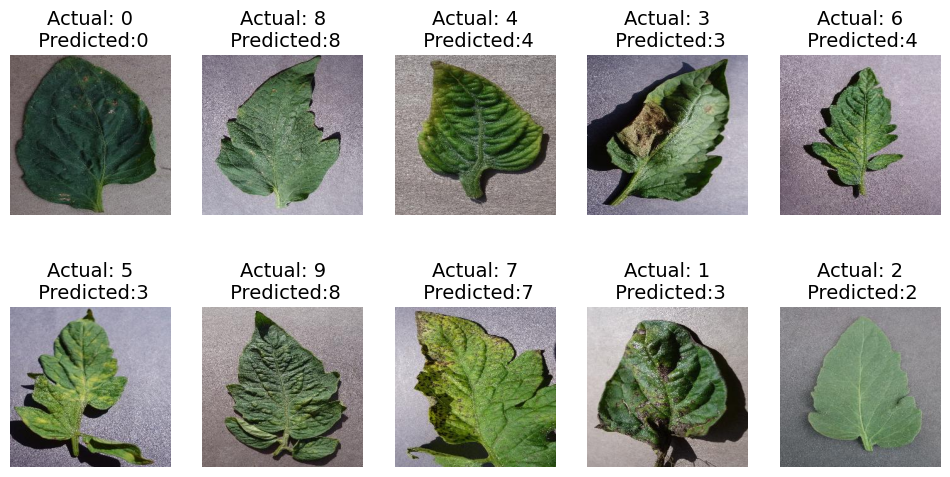

In [19]:
path = "train"
fig = plt.figure(figsize=(12,6))

for i,image in enumerate(val_df_final.groupby('Label').head(1)['Image'].values):    
    _ = plt.subplot(2,5,i+1)
    img = img_read(path,val_df_final[val_df_final['Image']==image]['Image'].head(1).values[0])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {val_df_final[val_df_final['Image']==image]['Label'].head(1).values[0]}\n Predicted:{val_df_final[val_df_final['Image']==image]['predicted'].head(1).values[0]}",fontsize=14)

In [20]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_plot(y_test,val_pred):
    fig, (ax1) = plt.subplots(nrows=1, figsize=(6, 6))
    sns.heatmap(confusion_matrix(y_test,val_pred), annot=True,fmt=".0f", cmap="Blues");
    ax1.set_title("Confusion Matrix")
    ax1.set_xlabel("Predicted Class")
    ax1.set_ylabel("Actual Class")
    ax1.yaxis.set_ticklabels(set(y_test),rotation=0)

### Confusion matrix for validation data

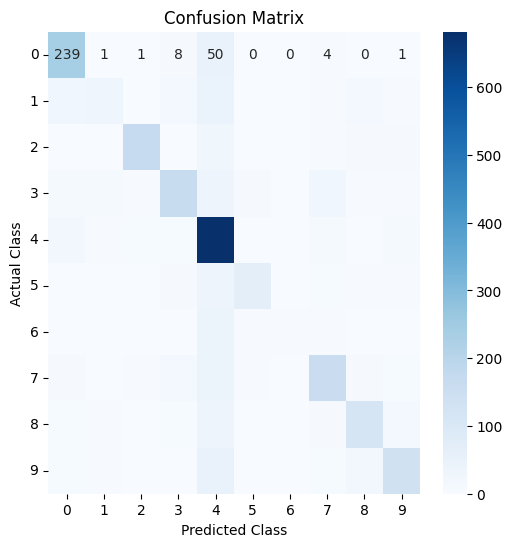

In [21]:
confusion_matrix_plot(y_test,val_pred)

### Create 1-D vector for test images

In [22]:
test_feat = createfeat("test",test)

C:\Users\Gandharv Kulkarni\AppData\Local\Temp\ipykernel_26960\3950331475.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm_notebook(df['Image']):


  0%|          | 0/5448 [00:00<?, ?it/s]

### Predict the test data

In [23]:
test_pre = clf.predict(test_feat)

### Submission dataframe

In [24]:
res = pd.DataFrame({'Label':test_pre})

In [25]:
res.to_csv("xgboost_baseline_1.csv",index=False)